<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <h1>Проектный практикум (3 семестр - учебная задача)</h1>
    <h2>Вступление</h2>
    <p>Цель данной работы - получение модели МО, способной генерировать текстовые отзывы о различных местах на основе определенных входных параметров, таких как категория места, средний рейтинг и ключевые слова. <a href="https://www.kaggle.com/datasets/kyakovlev/yandex-geo-reviews-dataset-2023">Датасет</a>, на основе которого необходимо решить поставленную задачу, представляет из себя набор русскоязычных отзывов об организациях, опубликованных на Яндекс-картах.</p>
</body>

In [12]:
# (ЗАПУСКАТЬ ВСЕГДА) Импорты

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import re

import torch
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from transformers import pipeline
from datasets import Dataset

warnings.filterwarnings('default')

In [2]:
# (ЗАПУСКАТЬ ВСЕГДА) Вспомогательная функция columns_info

def columns_info(source_df, max_number_of_unique_print = 6):
    print('Число столбцов: ' + str(source_df.shape[1]))
    print('Число строк:    ' + str(source_df.shape[0]) + ' (' + str(source_df.duplicated().sum()) + ' повторов)')
    column_name_max_len = 0
    column_type_max_len = 0
    for each in list(source_df.columns):
        if len(each) > column_name_max_len:
            column_name_max_len = len(each)
        if len(str(source_df[each].dtype)) > column_type_max_len:
            column_type_max_len = len(str(source_df[each].dtype))
    number_max_len = len(str(source_df.shape[0]))
    print(int(11 + column_name_max_len + 18 + number_max_len + 27 + number_max_len + 2 + column_type_max_len)*'-')
    for each_column in list(source_df.columns):
        res = 'Столбец ' + ('"' + each_column + '"').ljust(column_name_max_len + 2) + ' '
        number_of_nan = source_df[each_column].isnull().sum()
        res += 'Число пропусков: ' + str(number_of_nan if number_of_nan > 0 else '-').ljust(number_max_len) + ' '
        list_of_unique = list(source_df[each_column].unique())
        number_of_unique = len(list_of_unique)
        res += 'Число уникальных значений: ' + str(number_of_unique).ljust(number_max_len)
        res += ' ' + str(source_df[each_column].dtype).ljust(column_type_max_len) + ' '
        if number_of_unique <= max_number_of_unique_print:
            res += ' ' + str(list_of_unique)
        else:
            res += ' ' + str(list_of_unique[:max_number_of_unique_print])[:-1] + ', ...'
        print(res)


In [3]:
# (ЗАПУСКАТЬ ВСЕГДА) Установка random seed для воспроизводимости

SEED = 5553535

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <h2>Загрузка данных</h2>
    <p>Прочитаем и оценим данные.</p>
</body>

In [4]:
# (ЗАПУСКАТЬ ВСЕГДА) Загрузка датасета

# Так как скачать данные с указанного репозитория не получилось из-за:
# This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.
# Датасет был скачан с оригинального источника:
# https://www.kaggle.com/datasets/kyakovlev/yandex-geo-reviews-dataset-2023

DATASET_TSKV_PATH = "geo-reviews-dataset-2023.tskv"

# Чтение файла построчно и парсинг ключ=значение
data = []
with open(DATASET_TSKV_PATH, 'r', encoding='utf-8') as file:
    for line in file:
        # Разделяем строку по табуляции
        pairs = line.strip().split('\t')
        record = {}
        for pair in pairs:
            if '=' in pair:
                key, value = pair.split('=', 1)
                record[key.strip()] = value.strip()
        data.append(record)

# Создание DataFrame
df_raw = pd.DataFrame(data)
df = df_raw.copy(deep=True)

In [5]:
columns_info(df_raw)

Число столбцов: 5
Число строк:    500000 (1 повторов)
-----------------------------------------------------------------------------------
Столбец "address" Число пропусков: -      Число уникальных значений: 191916 object  ['Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников', 'Московская область, Электросталь, проспект Ленина, 29', 'Краснодар, Прикубанский внутригородской округ, микрорайон имени Петра Метальникова, улица Петра Метальникова, 26', 'Санкт-Петербург, проспект Энгельса, 111, корп. 1', 'Тверь, Волоколамский проспект, 39', 'Иркутская область, Черемхово, Первомайская улица, 199В', ...
Столбец "name_ru" Число пропусков: 970    Число уникальных значений: 148457 object  ['Московский квартал', 'Продукты Ермолино', 'LimeFit', 'Snow-Express', 'Студия Beauty Brow', 'Tele2', ...
Столбец "rating"  Число пропусков: -      Число уникальных значений: 6      object  ['3.', '5.', '1.', '4.', '2.', '0.']
Столбец "rubrics" Число пропусков: -      Число уникальных значений: 3179

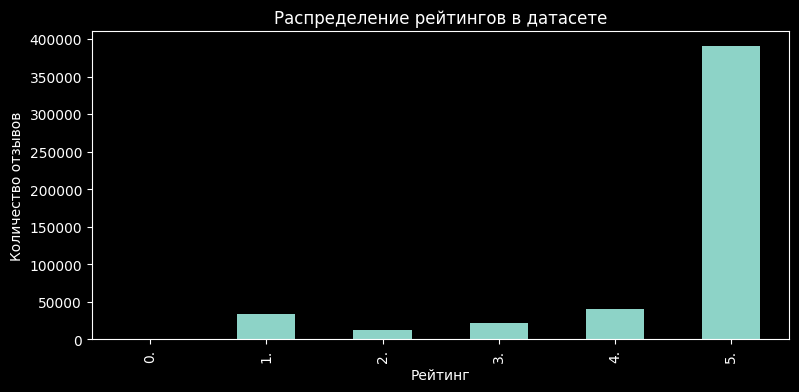

In [6]:
# Визуализация распределения рейтингов отзывов

plt.style.use('dark_background')
rating_counts = df_raw['rating'].value_counts().sort_index()
plt.figure(figsize=(9,4))
rating_counts.plot(kind='bar')
plt.title('Распределение рейтингов в датасете')
plt.xlabel('Рейтинг')
plt.ylabel('Количество отзывов')
plt.show()

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <p>Оценим имеющиеся данные и их потенциальную полезность для решения поставленной задачи:</p>
    <ul>
    <li>Столбец "<f-->address</f-->". Число уникальных значений составляет примерно треть от общего числа записей. В текущем виде использовать его для обучения будет непросто из-за того, что для значительной части данных для каждого конкретного местоположения будет слишком мало примеров отзывов. К тому же, организации могут открываться/закрываться/переезжать, поэтому пытаться привязывать отзывы к конкретным адресам не кажется слишком уж перспективной идеей. Можно было бы попробовать вычленить названия городов/областей, но это может стать потенциально неэтичным, т.к. у модели может появится предвзятость, основанная на конкретной локации (в каком-нибудь небольшом городке много плохих отзывов и поэтому даже у хорошего места отзыв может быть хуже, просто из-за его расположения, что может расстроить местных жителей). Было решено не использовать данный столбец для построения модели.</li>
    <li>Столбец "<f-->name_ru</f-->". Аналогично предыдущему столбцу - слишком много (~30 процентов) уникальных значений. К тому же, данный столбец содержит конкретные названия организаций, а не обобщенные категории мест (что требуется в задании). Если бы не было бы столбца "rubrics", то в теории можно было бы попытаться с помощью внешних источников по названиям фирм получить данные о категории места, но в нашем случае подобная информация у нас уже есть. Было решено так же не использовать данный столбец для построения модели.</li>
    <li>Столбец "<f-->rating</f-->". Данный столбец, очевидно, крайне необходим для нас, к тому же, он содержит всего 6 уникальных значений и практически сразу готов к использованию. Единственное, из-за экстремально низкого количества отзывов с оценкой 0, заменим их на оценку 1.</li>
    <li>Столбец "<f-->rubrics</f-->". Важнейший столбец, который содержит данные, которые можно одновременно интерпретировать как обобщенные категории мест, так и как ключевые слова.</li>
    <li>Столбец "<f-->text</f-->". Основной столбец с данными.</li>
    </ul>
    <p>Так же, немного забегая вперед и учитывая, что в качестве модели будет выбранная большая языковая модель на основе GPT-2, можно сказать что особо предобрабатывать данные не нужно, т.к. подобные модели обучались и рассчитаны именно на необработанные текстовые данные. Поэтому далее будет проведена лишь минимальная предобработка датасета.</p>
</body>

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <h2>Предобработка данных</h2>
    <p>Как уже было сказано ранее, в данной работе будет использоваться предобученная русскоязычная модель на основе GPT-2. Поэтому, в ячейке ниже, помимо базовой предобработки будет так же произведено финальное преобразование данных в один слолбец, который будет представлять из себя промт для GPT + пример желаемого текстового отзыва.</p>
</body>

In [7]:
# (ЗАПУСКАТЬ ВСЕГДА) Предобработка данных

# Преобразуем рейтинг к числу
df["rating"] = df["rating"].apply(lambda x: str(x)[0])
df["rating"] = df["rating"].apply(lambda x: str(1) if str(x) == '0' else str(x))
df["rating"] = df["rating"].astype(int)

# Примерно ограничим длину text, чтобы не обучать на совсем огромных:
df = df[df["text"].str.len() > 10]    # убираем совсем короткое
df = df[df["text"].str.len() < 2000]  # и слишком длинное (порог произвольный)

# В тексте была замечена неккоретная запись управляющего символа перевода строки
df["text"] = df["text"].apply(lambda x: re.sub(r'\\n', r'\n', x))

# Объединим rating и rubrics в один "промпт"
def make_prompt(rating, rubrics):
    return f"Rating: {rating:.1f} | Rubrics: {rubrics}\nОтзыв: "

df["prompt"] = df.apply(lambda row: make_prompt(row["rating"], row["rubrics"]), axis=1)

# Создадим общий текст для LM: prompt + отзыв
df["full_text"] = df["prompt"] + df["text"]

df = df.drop_duplicates(subset=['full_text'], keep=False)
df = df.reset_index(drop=True)

In [8]:
columns_info(df)

Число столбцов: 7
Число строк:    498222 (0 повторов)
-------------------------------------------------------------------------------------
Столбец "address"   Число пропусков: -      Число уникальных значений: 191572 object  ['Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников', 'Московская область, Электросталь, проспект Ленина, 29', 'Краснодар, Прикубанский внутригородской округ, микрорайон имени Петра Метальникова, улица Петра Метальникова, 26', 'Санкт-Петербург, проспект Энгельса, 111, корп. 1', 'Тверь, Волоколамский проспект, 39', 'Иркутская область, Черемхово, Первомайская улица, 199В', ...
Столбец "name_ru"   Число пропусков: 967    Число уникальных значений: 148126 object  ['Московский квартал', 'Продукты Ермолино', 'LimeFit', 'Snow-Express', 'Студия Beauty Brow', 'Tele2', ...
Столбец "rating"    Число пропусков: -      Число уникальных значений: 5      int32   [3, 5, 1, 4, 2]
Столбец "rubrics"   Число пропусков: -      Число уникальных значений: 31744  object  

In [9]:
# Случайный пример отзыва (промт + текст)

random_index = random.randint(0, df.shape[0]-1)

print()
print("Отзыв {:} (full_text):".format(random_index))
print()
print(df["full_text"].iloc[random_index])


Отзыв 104609 (full_text):

Rating: 4.0 | Rubrics: Строительный магазин
Отзыв: Сегодня зашел в магазин купить 5 мешков. Что-бы не ходить по всему магазину, спросил у кассира где их найти. В ответ услышал, проходите в зал , они там. Для чего спрашивал? Пошел в Леруа и купил, там более приветливый персонал. А сам магазин хороший.


In [10]:
#df = df.iloc[:1_000] # Закомментировать в финальной версии!

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <h2>Предобученная большая языковая модель (GPT-2-based)</h2>
    <p>Так как дообучение GPT занимает очень много времени и крайне требовательно к аппаратным ресурсам компьютера в качестве конкретной общедоступной версии GPT придется выбрать '<f-->sberbank-ai/rugpt3small_based_on_gpt2</f-->'. Данная модель даст не самые лучшие результаты, однако для учебного проекта её будет достаточно.</p>
</body>

In [11]:
# (ЗАПУСКАТЬ ВСЕГДА) Загрузка модели и соответствующего токенайзера, а так же проверка наличия и готовности GPU

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device

DEVICE = get_device()

# (~49Gb) одна из самых больших, свежих и высокооцененных общедоступных моделей на Hagging Face
#model_name = "ai-forever/ruGPT-3.5-13B"
# (~8.8Gb) так же популярная, свежая и более легковесная модель
#model_name = "ai-forever/rugpt3large_based_on_gpt2"
# (~3.2Gb) еще более легковесный вариант
#model_name = "sberbank-ai/rugpt2large"
# (~0.5Gb) легкая и не такая качественная, но весьма популярная модель со сравнительно низкими аппаратными требованиями
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"

warnings.filterwarnings('ignore')
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
warnings.filterwarnings('default')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060


<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
    <style>f--- {color: #e032e3}</style>
</head>
<body>
    <h2><f--->(всегда перезапускать до сюда (~30 секунд))</f---></h2>
</body>

In [12]:
# (пустая ячейка для нажатия 'Execute Above Cells')

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
    <style>w- {color: red}</style>
</head>
<body>
    <h2><w->(начало блока обучения)</w-></h2>
</body>

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <p>Подготовим наш датасет для дообучения выбранной предобученной GPT модели.</p>
    <p>*(Выполнение ячейки ниже занимает примерно <f->4 минуты 30 секунд</f-> (Intel Core i5-12400 + 32Gb-ddr5 + RTX3060(12Gb)))</p>
</body>

In [13]:
# (только для ячейки дообучения)

# GPT2 обычно не имеет токена начала/конца предложения, иногда помогает добавить:
tokenizer.pad_token = tokenizer.eos_token

# Превратим наш pandas DataFrame в huggingface Dataset:
hf_dataset = Dataset.from_pandas(df[["full_text"]])  # оставляем 1 столбец, где весь текст

# Функция токенизации
def tokenize_function(examples):
    return tokenizer(examples["full_text"],
                     truncation=True,
                     max_length=512,  # ограничиваем до 512, чтобы не переполнять
                     padding="max_length")

warnings.filterwarnings('ignore')
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=["full_text"])
warnings.filterwarnings('default')

# Разделим на train/test (90%/10%)
split = tokenized_dataset.train_test_split(test_size=0.1, seed=SEED)
train_dataset = split["train"]
eval_dataset = split["test"]

Map: 100%|██████████| 498222/498222 [04:20<00:00, 1914.63 examples/s]


In [14]:
# (только для ячейки дообучения)

# Trainer в transformers упрощает процесс fine-tuning. Нужно лишь указать TrainingArguments и передать датасеты.
# Для Language Modeling ключевым полем будет "labels", которые у нас совпадают с input_ids (shifted внутри).
# В tokenized_dataset токенайзер по умолчанию назвал эти поля ["input_ids", "attention_mask"].
# Для GPT2 формально нужны: input_ids, attention_mask и labels, причём labels=input_ids (сдвиг происходит внутри модели).
# Поэтому Trainer может сам это подхватить, если указать data_collator, который делает данные = inputs, labels.

# Подготовим data_collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Настраиваем TrainingArguments
training_args = TrainingArguments(
    output_dir="./trained_model",
    overwrite_output_dir=True,
    eval_strategy="steps",
    eval_steps=10_000,
    logging_strategy="no",
    save_strategy="no",
    #save_steps=10_000,
    num_train_epochs=1,             # обучение очень тяжелое, придется ограничиться 1 эпохой
    per_device_train_batch_size=8,  # оптимально для RTX3060(12Gb)
    per_device_eval_batch_size=8,
    warmup_steps=1_000,             # В финальной версии поставить 1_000 (!!!)
    weight_decay=0.01,              # L2 regularization
    learning_rate=5e-5,
    fp16=True,                      # Использовать 16-битные вычисления, если GPU поддерживает
    report_to="none",
)

# Создаём Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
    <style>w- {color: red}</style>
</head>
<body>
    <h2>(ВНИМАНИЕ!) Запуск дообучения</h2>
    <p>*(Выполнение ячейки ниже занимает примерно <f->7 (!) часов</f-> (Intel Core i5-12400 + 32Gb-ddr5 + RTX3060(12Gb)))</p>
</body>

In [15]:
# ~7 (!) часов обучения (НЕ ЗАПУСКАТЬ ПРОСТО ТАК!)

trainer.train()
trainer.save_model("./trained_model")

                                                         
 18%|█▊        | 10000/56050 [1:15:13<4:49:30,  2.65it/s]

{'eval_loss': 2.5753955841064453, 'eval_runtime': 725.901, 'eval_samples_per_second': 68.636, 'eval_steps_per_second': 8.58, 'epoch': 0.18}


                                                             
 36%|███▌      | 20000/56050 [2:30:12<3:46:59,  2.65it/s]

{'eval_loss': 2.5240678787231445, 'eval_runtime': 724.1229, 'eval_samples_per_second': 68.805, 'eval_steps_per_second': 8.601, 'epoch': 0.36}


                                                             
 54%|█████▎    | 30000/56050 [3:45:15<2:43:59,  2.65it/s]

{'eval_loss': 2.490081310272217, 'eval_runtime': 723.9136, 'eval_samples_per_second': 68.825, 'eval_steps_per_second': 8.603, 'epoch': 0.54}


                                                             
 71%|███████▏  | 40000/56050 [5:00:26<1:41:12,  2.64it/s]

{'eval_loss': 2.4654335975646973, 'eval_runtime': 725.2079, 'eval_samples_per_second': 68.702, 'eval_steps_per_second': 8.588, 'epoch': 0.71}


                                                            
 89%|████████▉ | 50000/56050 [6:15:32<38:05,  2.65it/s]

{'eval_loss': 2.4433090686798096, 'eval_runtime': 723.1426, 'eval_samples_per_second': 68.898, 'eval_steps_per_second': 8.612, 'epoch': 0.89}


100%|██████████| 56050/56050 [6:53:35<00:00,  2.26it/s]     


{'train_runtime': 24815.8855, 'train_samples_per_second': 18.069, 'train_steps_per_second': 2.259, 'train_loss': 2.5846069357716326, 'epoch': 1.0}


<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
    <style>w- {color: red}</style>
</head>
<body>
    <h2><w->(конец блока обучения)</w-></h2>
</body>

<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <h2>Тестирование дообученной модели</h2>
    <p>Возьмем несколько случайных примеров из датасета и попробуем на их основе сгенерировать отзывы.</p>
</body>

In [13]:
# (ЗАПУСКАТЬ ВСЕГДА) Подготовка функций для генерации отзывов

# Немного уточненная версия промта для генерации более корректного отзыва
def make_prompt_fix_version(rating, rubrics):
    """
    Формирует промпт для генерации отзыва на основе рейтинга и рубрик.

    Args:
        rating (float): Рейтинг (например, 5.0).
        rubrics (str): Рубрики (например, "Кафе;Ресторан").

    Returns:
        str: Формированный промпт.
    """

    if rating >= 4.0:
        sentiment = "Положительный"
    elif rating >= 3.0:
        sentiment = "Нейтральный"
    else:
        sentiment = "Отрицательный"
    return f"Rating: {rating} | Rubrics: {rubrics}\nОтзыв ({sentiment}): "

def generate_review(rating, rubrics, generation_pipeline, max_length=150, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, temperature=0.7):
    """
    Генерирует отзыв на основе заданного рейтинга и рубрик с учётом настроения.

    Args:
        rating (float): Рейтинг (например, 5.0).
        rubrics (str): Рубрики (например, "Кафе;Ресторан").
        generation_pipeline: Пайплайн для генерации.
        max_length (int, optional): Максимальная длина генерируемого текста (включая промпт). Defaults to 150.
        num_return_sequences (int, optional): Количество генерируемых последовательностей. Defaults to 1.
        do_sample (bool, optional): Использовать ли семплирование. Defaults to True.
        top_k (int, optional): Параметр top_k для семплирования. Defaults to 50.
        top_p (float, optional): Параметр top_p для семплирования. Defaults to 0.95.
        temperature (float, optional): Температура для семплирования. Defaults to 0.99.

    Returns:
        list of str: Сгенерированные отзывы.
    """

    # Формируем промпт
    prompt = make_prompt_fix_version(rating, rubrics)

    # Генерируем текст
    generated = generation_pipeline(
        prompt,
        truncation=True,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=do_sample,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature
    )

    # Возвращаем только сгенерированный текст без промпта
    return [gen['generated_text'].replace(prompt, '').strip() for gen in generated]

def clean_review(text):
    """
    Очищает текст от лишних символов и обрезает его до последнего знака препинания.

    Args:
        text (str): Исходный текст отзыва.

    Returns:
        str: Очищенный и обрезанный отзыв.
    """

    if not isinstance(text, str):
        return ""

    # Заменяем все типы пробельных символов (включая переносы строк) на один пробел
    text = re.sub(r'\s+', ' ', text)

    # Удаляем символы переноса строки, если они остались
    text = text.replace('\\n', ' ').replace('\n', ' ')

    # Удаляем отдельные 'n' перед заглавными буквами, которые могли возникнуть из-за '\n'
    text = re.sub(r'n([А-ЯA-Z])', r'\1', text)

    # Ищем позицию последнего знака препинания (точка, восклицательный или вопросительный знак)
    matches = list(re.finditer(r'[.!?]', text))
    if matches:
        last_match = matches[-1]
        end = last_match.end()
        text = text[:end]

    # Удаляем нежелательные символы, оставляя только буквы, цифры и стандартные знаки препинания
    text = re.sub(r'[^\w\s.,!?;:-]', '', text)
    text = re.sub(r'(?<=[^а-яА-Я])-(?=[^а-яА-Я])', '', text)
    text = re.sub(r'^-', '', text)

    # Удаляем повторы слов, идущие друг за другом
    text = re.sub(r'(^|[^а-яА-Я])(([а-яА-Я]{1,})(?:([^а-яА-Я]{1,})\3){1,})([^а-яА-Я]|$)', r'\1\3\5', text)

    # Убираем лишние пробелы в начале и конце текста
    text = text.strip()

    # Удаляем пустой пункт перечисления, если он последний в тексте
    text = re.sub(r'[0-9]{1,}\.$', r'', text)
    text = text.strip()

    # Удаляем все лишние вподряд идущие пробелы
    text = re.sub(r'[ ]{2,}', ' ', text)

    return text

In [14]:
# (ЗАПУСКАТЬ ВСЕГДА) (перезапускать для других примеров) Случайный список примеров для генерации

r_inx_1 = random.choice(list(df.loc[df['rating'] == 1].index))
r_inx_2 = random.choice(list(df.loc[df['rating'] == 2].index))
r_inx_3 = random.choice(list(df.loc[df['rating'] == 3].index))
r_inx_4 = random.choice(list(df.loc[df['rating'] == 4].index))
r_inx_5_1 = random.choice(list(df.loc[df['rating'] == 5].index))
r_inx_5_2 = random.choice(list(df.loc[df['rating'] == 5].index))
r_inx_5_3 = random.choice(list(df.loc[df['rating'] == 5].index))

review_params = [
    {"rating": float(df['rating'].iloc[r_inx_1]), "rubrics": df['rubrics'].iloc[r_inx_1]},
    {"rating": float(df['rating'].iloc[r_inx_2]), "rubrics": df['rubrics'].iloc[r_inx_2]},
    {"rating": float(df['rating'].iloc[r_inx_3]), "rubrics": df['rubrics'].iloc[r_inx_3]},
    {"rating": float(df['rating'].iloc[r_inx_4]), "rubrics": df['rubrics'].iloc[r_inx_4]},
    {"rating": float(df['rating'].iloc[r_inx_5_1]), "rubrics": df['rubrics'].iloc[r_inx_5_1]},
    {"rating": float(df['rating'].iloc[r_inx_5_2]), "rubrics": df['rubrics'].iloc[r_inx_5_2]},
    #{"rating": float(df['rating'].iloc[r_inx_5_3]), "rubrics": df['rubrics'].iloc[r_inx_5_3]},
    {"rating": 5.0, "rubrics": "Кафе;Ресторан"},
    {"rating": 4.0, "rubrics": "Супермаркет;Магазин продуктов"},
]

random.shuffle(review_params)

In [15]:
# (ЗАПУСКАТЬ ВСЕГДА) (перезапускать для других отзывов для тех же примеров) Генерация отзывов

# Создаём пайплайн генерации (text-generation)
generation_pipeline = pipeline(
    "text-generation",
    model="./trained_model",  # путь к нашей дообученной модели
    tokenizer=tokenizer,
    device=DEVICE
)

# Генерируем отзывы
generated_reviews = []
for params in review_params:
    reviews = generate_review(rating=params["rating"], rubrics=params["rubrics"], generation_pipeline=generation_pipeline)
    for review in reviews:
        generated_reviews.append({
            "Rating": params["rating"],
            "Rubrics": params["rubrics"],
            "Review": review
        })

# Создаём DataFrame
df_generated_reviews = pd.DataFrame(generated_reviews)

# Применяем функцию очистки к столбцу 'Review'
df_generated_reviews['Cleaned_Review'] = df_generated_reviews['Review'].apply(clean_review)

# Выводим обновлённую таблицу
df_generated_reviews['Rating'] = df_generated_reviews['Rating'].astype(int)
with pd.option_context('display.max_colwidth', 200):
    display(pd.DataFrame(df_generated_reviews[['Rating', 'Rubrics', 'Cleaned_Review']]).style.set_properties(**{'text-align': 'left'}).hide(axis=0))

Device set to use cuda


Rating,Rubrics,Cleaned_Review
5,Супермаркет,"Выбор товаров хороший, персонал отзывчивый, всегда можно найти, что нужно. Внутри магазин чистый, ассортимент большой. В магазине всегда есть кассы самообслуживания, что очень удобно. Есть отдел готовой еды и алкогольных напитков. В магазине много товаров, которых не встретишь в других магазинах. Есть отдел с товарами, которые не продаются в других магазинах. Также можно приобрести товары по акции. Но есть ряд товаров, которые не очень радуют."
1,Кондитерская;Пекарня;Быстрое питание,"1. Вкусно, но в последний раз, когда я зашла, был просто ужас. 2. Я не смогла даже сфотографировать. 3. Пришла, забрала, а там просто какой то ужас. 4. Я попросила продавца-кассира, чтобы он показал мне, где лежит мой заказ. 5. Я не смогла выбрать. 6. После чего продавец-кассир начала мне рассказывать про то, что я заказывала и сколько раз."
2,"Ресторан;Бар, паб;Спортбар","Заведение очень атмосферное, но вот еда подкачала. Заехали случайно в него по рекомендации и ни разу не пожалели. Начнём с того, что мы были в зале на втором этаже. Зал небольшой, но уютный. Мы заказали блюдо из рыбы, салат, пасту и пиццу. Паста: 1. Очень мало специй и майонеза. 2. Паста была сухая, а пицца вообще не вкусная, даже не соленая. 3. Паста:"
4,Супермаркет;Магазин продуктов,"Приехали в магазин с ребенком, нам предложили место на втором этаже. Магазин находится в подвальном помещении. Поставил бы 5 звезд, если бы не одно НО. Долго искали место, где можно купить продукты питания, не особо большой выбор, но все равно нужно зайти и купить что-то. На входе нас встретила кассир не помню имя и попросила дать нам одноразовые тарелки для еды, мы отказались и ушли."
3,Гостиница,"Из плюсов: 1. Еда очень вкусная шведский стол, в основном, все что заказывали, вкусно 2. Чисто, аккуратно не много было мусора, что приятно 3. Персонал вежливый и отзывчивый не смотря на то, что в номерах было очень жарко 4. Номера чистые и уютные. Из минусов: 1. При входе в отель не было никаких указателей, но по факту оказалось, что они есть, но мы не знали где их найти."
5,Кафе;Ресторан,"Приятная атмосфера, дружелюбный персонал, хорошая кухня. Кухня, как и во всех заведениях этой сети на высоте. По поводу еды: очень вкусные блюда; не дорого; много места; есть столики на любой вкус; на веранде всегда тихо и спокойно; в зале достаточно места; не шумно; есть туалет. По поводу обслуживания: во время посещения всегда есть кто-то из персонала, чтобы принять заказ."
5,Театр;Концертный зал;Театрально-концертная касса,"Впервые побывали в Театре на Таганке в январе 2023 года и остались в восторге от увиденного. Отмечу: 1. Театр небольшой, но уютный, современный, с прекрасной акустикой и удобными креслами. 2. Персонал очень вежливый, приветливый, всегда готовы помочь и ответить на все вопросы. 3. В театре тепло и уютно. 4. Актёрская работа очень качественная."
4,Магазин хозтоваров и бытовой химии;Крепёжные изделия;Лакокрасочные материалы;Магазин сантехники;Строительный магазин,"1. Хороший ассортимент товаров для дома. 2. Всегда можно найти то, что нужно. 3. На кассах самообслуживания всегда вежливые и доброжелательные кассиры. 4. Цены не высокие. 5. Очень много акций и скидок. 6. Есть бонусная программа. 7. Всегда есть возможность оплатить товар, если нужно. 8. Много акций и скидок. 9. Есть рассрочка на товар."


<head>
    <style>h1 {font-size: 30px; text-align: center; color: #ff8c00}</style>
    <style>h2 {font-size: 26px; text-align: left; color: #ff8c00}</style>
    <style>p  {font-size: 18px; text-align: left}</style>
    <style>f- {color: #ff8c00}</style>
    <style>f-- {color: #71e1fe}</style>
</head>
<body>
    <h2>Итоги</h2>
    <p>Как видно, <f-->'sberbank-ai/rugpt3small_based_on_gpt2'</f--> с одной эпохой дообучения справляется с поставленной задачей достаточно посредственно. В рамках учебного проекта и ограниченного времени и аппаратных ресурсов, остановимся на текущем результате. Тем не менее, отметим потенциальные пути улучшения качества генерации модели:</p>
    <ul>
    <li>Во-первых, при наличии достаточных вычислительных мощностей, можно было бы выбрать более тяжеловесную и продвинутую версию GTP.</li>
    <li>Во-вторых, аналогично, можно было бы увеличить число эпох обучения (хотя бы до 2-3).</li>
    <li>В-третьих, можно было бы дополнительно поэкспериментировать с промтами (как с тем, что использовался для дообучения, так и с генеративным видоизмененным промтом).</li>
    <li>В-четвертых, можно было бы попробовать модифицировать и дополнительно предобработать датасет.</li>
    </ul>
    <p>По идее, последние два пункта не требуют напрямую большого количества времени и аппаратных ресурсов для реализации. Однако, проблемой является тот факт, что для проверки того, как очередные изменения повлияли на конечный результат, необходимо снова переобучать модель. Причем, делать это придется много раз, постоянно то добавляя, то убирая какие-то конкретные изменения. При этом, проведение тестов только на малой части данных так же определенно будет оказывать влияние на итоговый результат (так как для больших языковых моделей количество практически всегда переходит в качество) и может искажать влияние конкретных изменений. И, помимо всего вышесказанного, сама модель <f-->'sberbank-ai/rugpt3small_based_on_gpt2'</f--> является не такой уж высококачественной (однако даже она весьма требовательна к "железу"), поэтому, вероятно, иногда даже хорошие улучшения будут теряться и не особо отражаться на конечном качестве модели, что еще сильнее затруднит проведение экспериментов по улучшению качества генерации отзывов. Тем не менее, в результате выполнения данного проекта были приобретены практические навыки работы с GPT-подобными моделями, поэтому в целом выполнение учебного проекта можно считать умеренно успешным и завершенным.</p>
</body>